# **SMS TEXT CLASSIFIER**
---



# **IMPORTING LIBRARIES**
---

In [6]:
#For Data Manipulation
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack
from collections import Counter

#For Warnings Handeling
import warnings
warnings.filterwarnings('ignore')

#For Model Dumping
import pickle

#For Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


#For Data Splitting
from sklearn.model_selection import train_test_split

#For Converting Text into Vectors
from sklearn.feature_extraction.text import TfidfVectorizer

#For Training
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer

#For Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#For HyperParamerts tuning
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Loading The DataSet**
---

In [7]:
dataset_url = "https://raw.githubusercontent.com/arpitmishra447/Projects/master/sms_spam_classifier/dataset/spam.csv"
df = pd.read_csv(dataset_url, encoding="latin-1")

# **Data Exploration and Manipulation**
---

In [8]:
df.shape #for finding shape of the dataframe

(5572, 5)

In [9]:
df.columns #for checking columns names of dataframe

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [10]:
df.head() #for checking few instances of the dataframe

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
df.describe() #for checking basic stastical description

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [12]:
df.info() #for checking basic information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [13]:
df.notnull().sum() #since shape was 5572*5 we have many null values in unnamed:(2,3,4) since these columns has so many null values it seems like these columns are not that useful

,0
v1,5572
v2,5572
Unnamed: 2,50
Unnamed: 3,12
Unnamed: 4,6


In [14]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True) #dropping these columns

In [15]:
df.duplicated().sum() #checking for duplicate instances

np.int64(403)

In [16]:
# from the result we can say we have 403 duplicate rows
df.drop_duplicates(inplace=True) #droping the duplicate instances
df.duplicated().sum() #checking for duplicate instances just to make sure all are removed

np.int64(0)

In [17]:
#renaming v1 and v2 for make it more presentable and understandable
df.rename(columns={'v1':'label','v2':'message'},inplace=True)

In [18]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
df['label'].value_counts() #Cheking for unique Values of Labels and for data distribution

,count
label,
ham,4516
spam,653


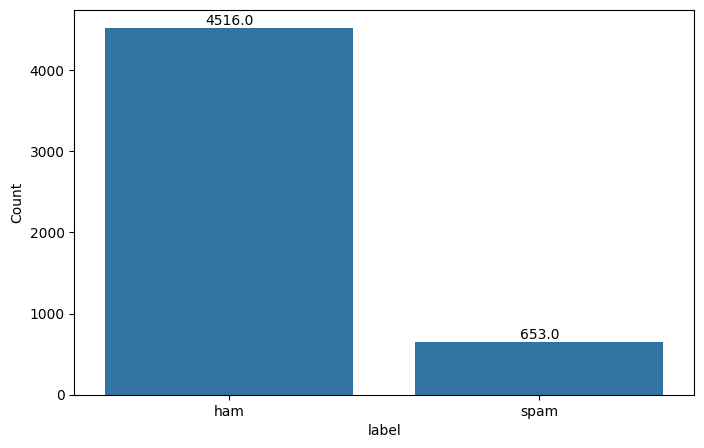

In [20]:
counts = df['label'].value_counts().reset_index()
counts.columns = ['label', 'Count']

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='label', y='Count', data=counts)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.show()

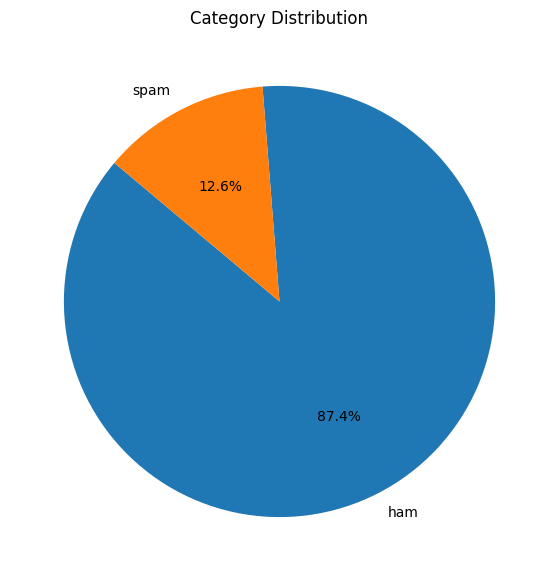

In [21]:
plt.figure(figsize=(7, 7))
plt.pie(df['label'].value_counts(),labels=['ham','spam'], autopct='%1.1f%%', startangle=140)

plt.title('Category Distribution')
plt.show()

In [22]:
# from the evaluation we can see there is a huge data imbalance between both the categories
# we can handel that using class_weight='balanced' in our model while training

**what should we do about the text**

Clean the text: Lowercase, remove punctuation, numbers, and special characters.

Tokenization: Break sentences into words.

Stopword Removal: Remove common words like "is", "the", "in" which do not carry important meaning.

Stemming/Lemmatization: Reduce words to their base form.

In [23]:
#function for cleaning text
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)  # Remove non-alphabetic characters
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [24]:
# trying clean_text function
print(clean_text("this a sample test for the function"))

sample test function


In [25]:
#Trying Feature Engineering to get basic length based features
def extract_features(text):
    # Feature calculations based on your code
    char_count = len(text)
    word_count = len(text.split())
    capitals_count = sum(1 for c in text if c.isupper())
    special_char_count = sum(1 for c in text if not c.isalnum() and c != ' ')
    has_url = int('http' in text or 'www' in text)
    digit_count = sum(1 for c in text if c.isdigit())

    #Clean the text
    cleaned_text = clean_text(text)

    # Build the feature dataframe
    features = pd.DataFrame([{
        'char_count': char_count,
        'word_count': word_count,
        'capitals_count': capitals_count,
        'special_char_count': special_char_count,
        'has_url': has_url,
        'digit_count': digit_count,
        'clean_message': cleaned_text
    }])

    return features

In [26]:
df_features=pd.DataFrame([extract_features(text).iloc[0] for text in df['message']])

In [27]:
df_features.head()

,char_count,word_count,capitals_count,special_char_count,has_url,digit_count,clean_message
0,111,20,3,9,0,0,go jurong point crazy available bugis n great ...
0,29,6,2,6,0,0,ok lar joking wif u oni
0,155,28,10,6,0,25,free entry wkly comp win fa cup final tkts st ...
0,49,11,2,6,0,0,u dun say early hor u c already say
0,61,13,2,2,0,0,nah think go usf life around though


In [28]:
df = pd.concat([df.reset_index(drop=True), df_features.reset_index(drop=True)], axis=1)

In [29]:
#Label Encoding for column Label
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [30]:
df.head()

,label,message,char_count,word_count,capitals_count,special_char_count,has_url,digit_count,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",111,20,3,9,0,0,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,6,2,6,0,0,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,6,0,25,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,11,2,6,0,0,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,2,2,0,0,nah think go usf life around though


In [31]:
#using TF-IDF Vectorization for converting text into numerical features
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,3))  # Using unigrams + bigrams
X_tfidf = tfidf.fit_transform(df['clean_message'])

In [32]:
#stacking all the features together
X_additional = df[['char_count', 'word_count', 'capitals_count', 'special_char_count', 'has_url', 'digit_count']].values
X_final = hstack((X_tfidf, X_additional))
y = df['label'].values

# **Checking for top 20 spam and ham words**

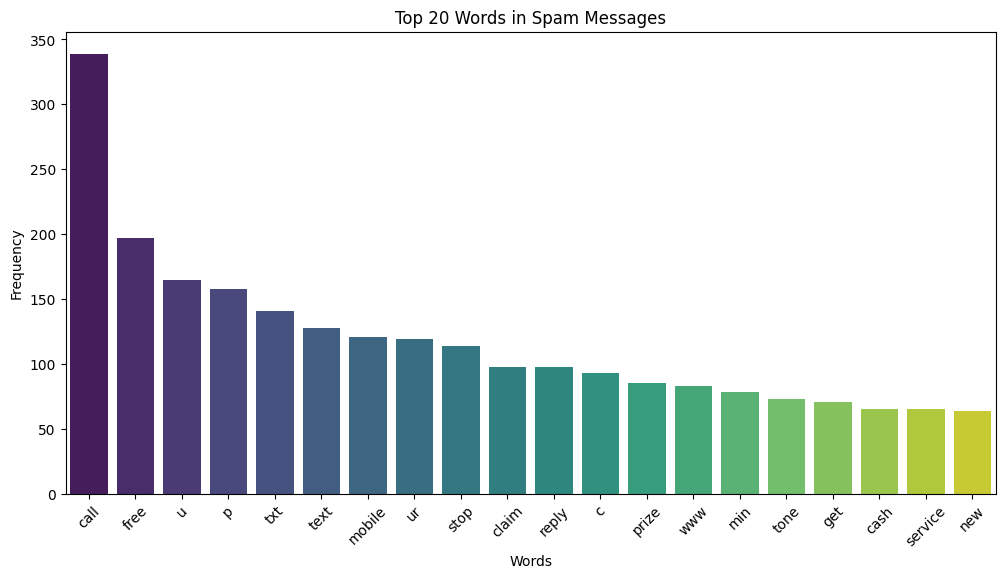

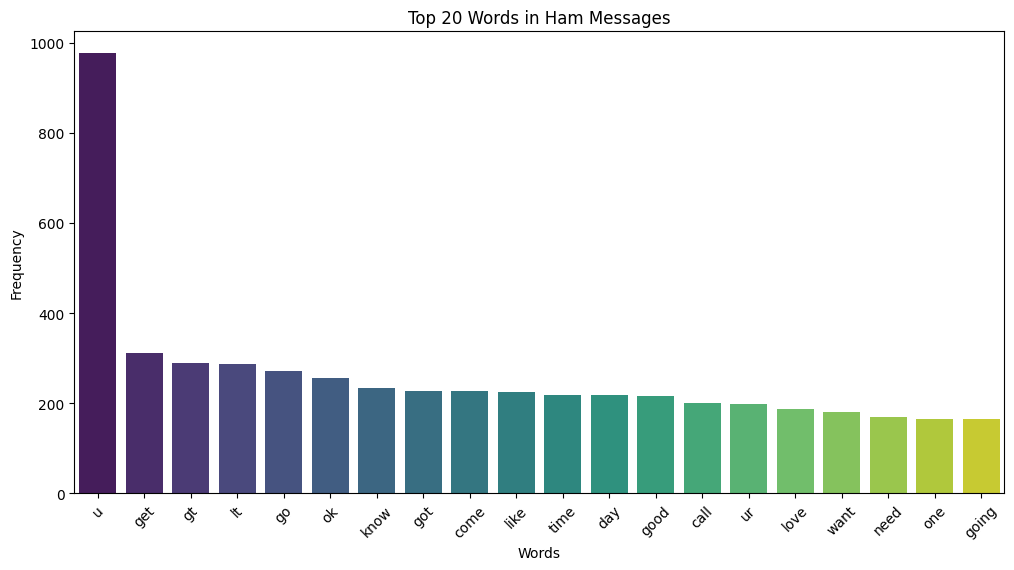

In [33]:
# Separate Spam and Ham
spam_messages = df[df['label'] == 1]['clean_message']
ham_messages = df[df['label'] == 0]['clean_message']

# Tokenize and get word counts
def get_word_counts(messages):
    all_words = ' '.join(messages).split()
    return Counter(all_words)

spam_word_counts = get_word_counts(spam_messages)
ham_word_counts = get_word_counts(ham_messages)

# Get most common words
most_common_spam = spam_word_counts.most_common(20)
most_common_ham = ham_word_counts.most_common(20)

# Plotting function
def plot_word_frequencies(word_counts, title):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(words), y=list(counts), palette='viridis')
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    plt.xticks(rotation=45)
    plt.show()

# Plot Spam Words
plot_word_frequencies(most_common_spam, 'Top 20 Words in Spam Messages')

# Plot Ham Words
plot_word_frequencies(most_common_ham, 'Top 20 Words in Ham Messages')

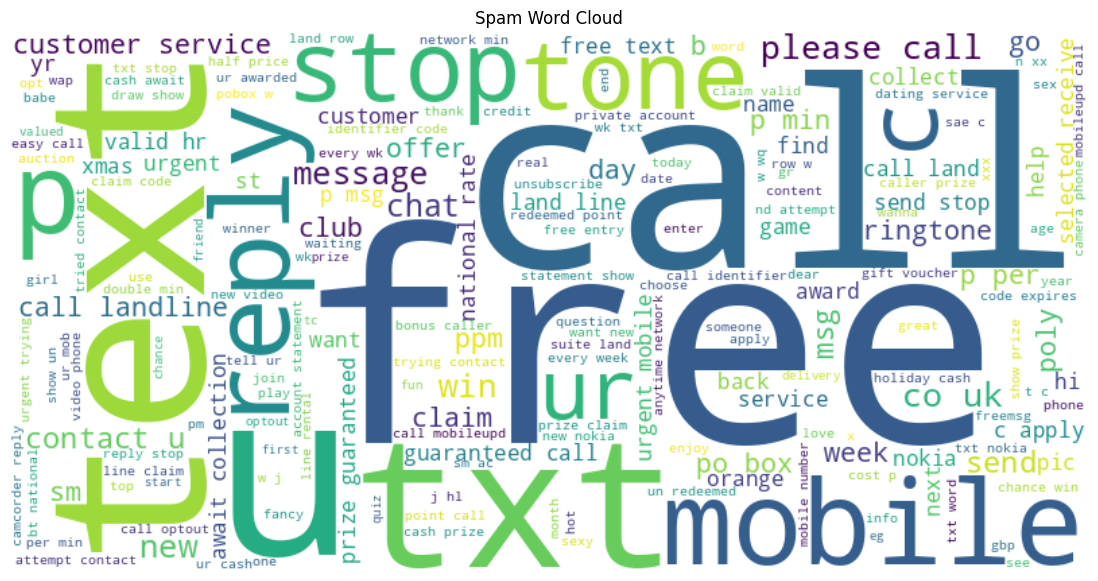

In [34]:
# Word Cloud for Spam
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_messages))
plt.figure(figsize=(15, 7))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Spam Word Cloud')
plt.show()

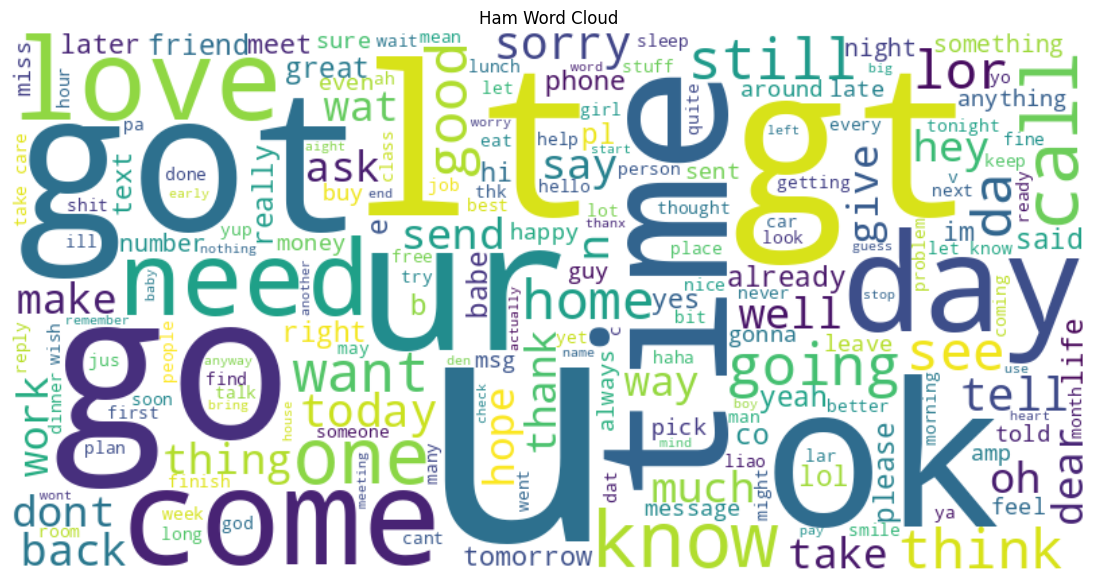

In [35]:
# Word Cloud for Ham
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ham_messages))
plt.figure(figsize=(15, 7))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Ham Word Cloud')
plt.show()

# **Training the Models**
---

In [36]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)
spw=np.count_nonzero(y_train == 0)/np.count_nonzero(y_train == 1)
# List of models to compare
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Linear SVM": LinearSVC(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight={0:1, 1:2}, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGboost": XGBClassifier(random_state=42, scale_pos_weight=spw)
}

In [37]:
# Function to train and evaluate models
for name, model in models.items():
    print(f"\n Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


 Training: Naive Bayes
Accuracy: 0.9536
Classification Report:
               precision    recall  f1-score   support

         Ham       0.98      0.96      0.97       903
        Spam       0.78      0.88      0.83       131

    accuracy                           0.95      1034
   macro avg       0.88      0.92      0.90      1034
weighted avg       0.96      0.95      0.95      1034

Confusion Matrix:
 [[871  32]
 [ 16 115]]

 Training: Logistic Regression
Accuracy: 0.9816
Classification Report:
               precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       903
        Spam       0.93      0.92      0.93       131

    accuracy                           0.98      1034
   macro avg       0.96      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034

Confusion Matrix:
 [[894   9]
 [ 10 121]]

 Training: Linear SVM
Accuracy: 0.9884
Classification Report:
               precision    recall  f1-score   support

     


Classifier Performance Summary (Sorted by Accuracy):

            Classifier  Accuracy  Spam Precision  Spam Recall  Spam F1-Score
0           Linear SVM    0.9884            0.98         0.93           0.95
1        Random Forest    0.9884            1.00         0.91           0.95
2              XGBoost    0.9874            0.93         0.98           0.95
3    Gradient Boosting    0.9836            0.97         0.90           0.93
4  Logistic Regression    0.9816            0.93         0.92           0.93
5          Naive Bayes    0.9536            0.78         0.88           0.83


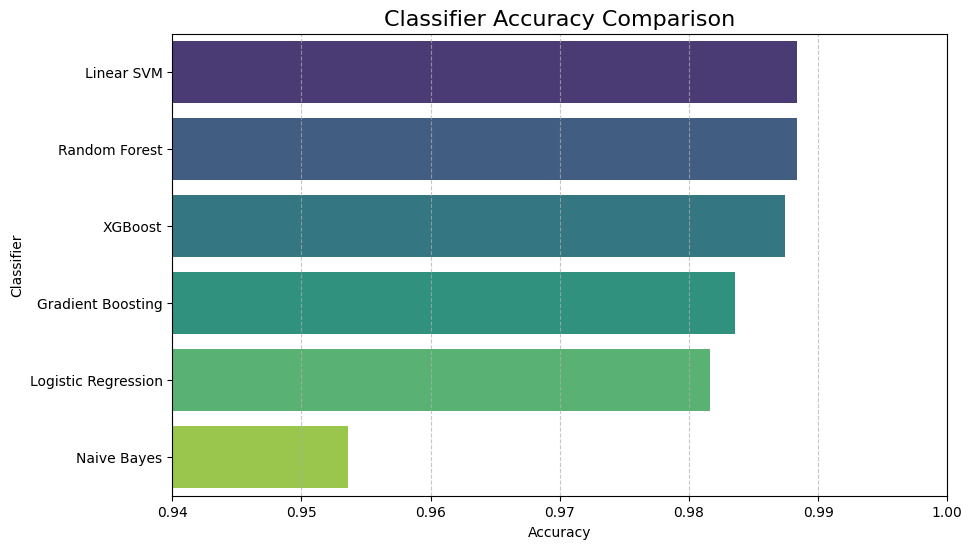

In [38]:
# Classifier Performance Data
data = {
    'Classifier': [
        'Naive Bayes',
        'Logistic Regression',
        'Gradient Boosting',
        'XGBoost',
        'Linear SVM',
        'Random Forest'
    ],
    'Accuracy': [0.9536, 0.9816, 0.9836, 0.9874, 0.9884, 0.9884],
    'Spam Precision': [0.78, 0.93, 0.97, 0.93, 0.98, 1.00],
    'Spam Recall': [0.88, 0.92, 0.90, 0.98, 0.93, 0.91],
    'Spam F1-Score': [0.83, 0.93, 0.93, 0.95, 0.95, 0.95]
}

# Create DataFrame
df_metrics = pd.DataFrame(data)

# Sort by Accuracy
df_sorted = df_metrics.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Display Sorted Table
print("\nClassifier Performance Summary (Sorted by Accuracy):\n")
print(df_sorted)

# Plotting Bar Chart for Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Classifier', data=df_sorted, palette='viridis')
plt.title('Classifier Accuracy Comparison', fontsize=16)
plt.xlabel('Accuracy')
plt.ylabel('Classifier')
plt.xlim(0.94, 1.00)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

**Trying Hyperparameter tuning on the best 3 classifiers**

In [39]:
# Define parameter grid for RandomForest Classifier
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

# GridSearch
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best Random Forest Params:", grid_rf.best_params_)
print("Best Random Forest Score:", grid_rf.best_score_)


Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Best Random Forest Score: 0.95131729488066


Accuracy: 0.9913
Classification Report:
               precision    recall  f1-score   support

         Ham       0.99      1.00      1.00       903
        Spam       1.00      0.93      0.96       131

    accuracy                           0.99      1034
   macro avg       1.00      0.97      0.98      1034
weighted avg       0.99      0.99      0.99      1034



<Axes: >

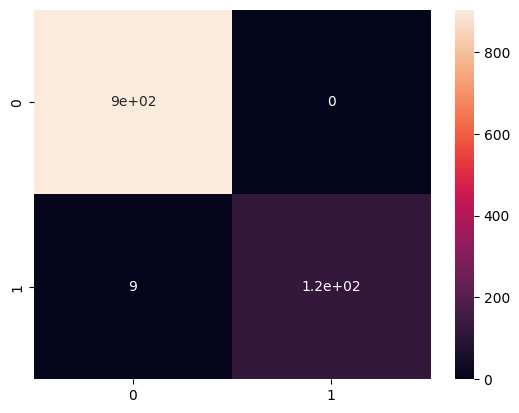

In [40]:
best_rf = grid_rf.best_estimator_
y_pred_rf = grid_rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=['Ham', 'Spam']))
sns.heatmap(confusion_matrix(y_test, y_pred_rf),annot=True)

In [41]:
# Define parameter grid for LinearSVC
svm = LinearSVC(class_weight='balanced', max_iter=5000)

# Grid Search Parameters
param_grid = {'C': [0.01, 0.1, 1, 10]}

# Grid Search
grid_svm = GridSearchCV(svm, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)

print("Best SVM Params:", grid_svm.best_params_)
print("Best SVM Score:", grid_svm.best_score_)

Best SVM Params: {'C': 0.1}
Best SVM Score: 0.9219917457887141


Accuracy: 0.9826
Classification Report:
               precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       903
        Spam       0.93      0.93      0.93       131

    accuracy                           0.98      1034
   macro avg       0.96      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034



<Axes: >

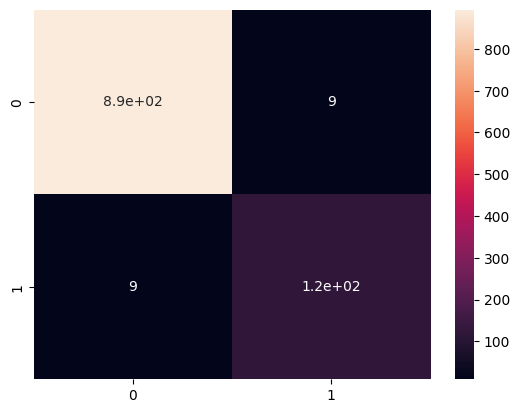

In [42]:
# Evaluate
best_svm = grid_svm.best_estimator_
y_pred_svm = grid_svm.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm, target_names=['Ham', 'Spam']))
sns.heatmap(confusion_matrix(y_test, y_pred_svm),annot=True)

In [43]:
# Baseline XGBoost Model

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=spw,
    random_state=42
)

# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
grid_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='f1', verbose=2)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
Accuracy: 0.9913

Classification Report:
               precision    recall  f1-score   support

         Ham       1.00      0.99      1.00       903
        Spam       0.96      0.98      0.97       131

    accuracy                           0.99      1034
   macro avg       0.98      0.99      0.98      1034
weighted avg       0.99      0.99      0.99      1034



<Axes: >

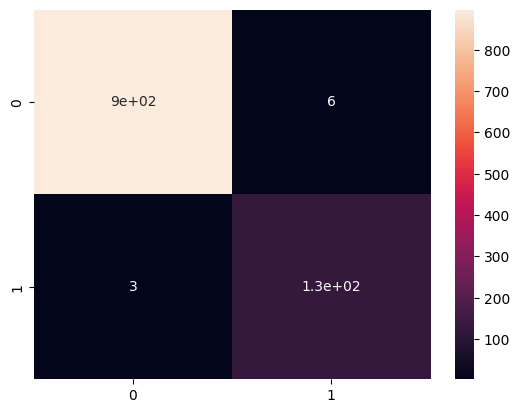

In [44]:
# Evaluation
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print(f"Best Parameters: {grid_xgb.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=['Ham', 'Spam']))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb),annot=True)

In [45]:
# Create Ensemble with Tuned Models
ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf),      # Your tuned Random Forest
        ('xgb', best_xgb)     # Your tuned XGBoost
    ],
    voting='soft',   # Soft voting to use predicted probabilities
    n_jobs=-1
)

# Train Ensemble
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     min_samples_split=10,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_type...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 n_jobs=-1, voting='soft')


Ensemble Accuracy: 0.9932

Classification Report:
               precision    recall  f1-score   support

         Ham       1.00      1.00      1.00       903
        Spam       0.98      0.97      0.97       131

    accuracy                           0.99      1034
   macro avg       0.99      0.98      0.98      1034
weighted avg       0.99      0.99      0.99      1034



<Axes: >

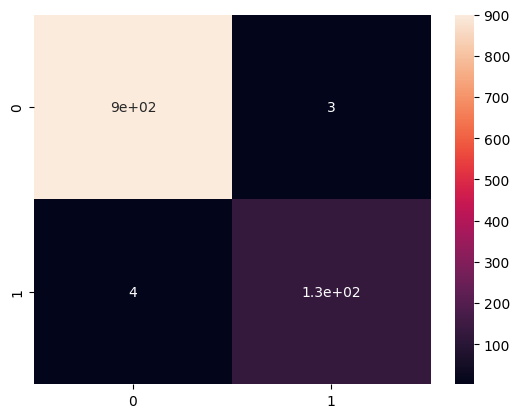

In [46]:
#evaluation
# Predict and Evaluate
y_pred = ensemble.predict(X_test)

print(f"\nEnsemble Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)

# **Best Model- Ensemble of Random Forest And XgBoost which gives accuracy of 0.9932**

In [47]:
import joblib

# Save the ensemble model
joblib.dump(ensemble, 'best_model.pkl')

#Save the tfidf model
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [48]:
import sklearn
import collections
import matplotlib
import xgboost
import wordcloud

In [49]:
print(f"numpy=={np.__version__}",end=" ")
print(f"scikit-learn=={sklearn.__version__}",end=" ")
print(f"pandas=={pd.__version__}",end=" ")
print(f"matplotlib=={matplotlib.__version__}",end=" ")
print(f"seaborn=={sns.__version__}",end=" ")
print(f"nltk=={nltk.__version__}",end=" ")
print(f"joblib=={joblib.__version__}",end=" ")
print(f"xgboost=={xgboost.__version__}",end=" ")
print(f"wordcloud=={wordcloud.__version__}",end=" ")

numpy==2.0.2 scikit-learn==1.6.1 pandas==2.2.2 matplotlib==3.10.0 seaborn==0.13.2 nltk==3.9.1 joblib==1.5.1 xgboost==2.1.4 wordcloud==1.9.4 

In [50]:
!python --version

Python 3.11.13
